## Notebook for going from the kwik files (kwd/kwe/kwik) to rasters
Uses:
    - intan2kwik (https://github.com/zekearneodo/intan2kwik/blob/master/README.md)
    - mountainlab suite(https://github.com/flatironinstitute/mountainlab-js)
    - mountainsort https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
    - mountainsort examples https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md

In [1]:
import socket
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload


import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

from pipefinch.pipeline import filestructure as et
from pipefinch.h5tools.kwik import kwdfunctions as kwdf


2019-03-01 16:59:28,055 - root - INFO - Logger set
2019-03-01 16:59:28,056 - root - INFO - Hostname zinch


### Session parameters and raw files

In [2]:
sess_par = {'bird': 'p1j1',
           'sess': '2019-02-27_1800_02', 
           'probe': 'probe_0'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], live_like_animals=True)

logger.info('Raw folder {}'.format(exp_struct['folders']['raw']))


kwik_folder = exp_struct['folders']['kwik']
kwd_path = exp_struct['files']['kwd']
exp_struct

2019-03-01 16:59:28,440 - root - INFO - Raw folder /mnt/zuperfinchjr/Data/p1j1/Ephys/raw/2019-02-27_1800_02


{'folders': {'raw': '/mnt/zuperfinchjr/Data/p1j1/Ephys/raw/2019-02-27_1800_02',
  'kwik': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02',
  'msort': '/media/zinch/Windows/experiment/p1j1/Ephys/msort/2019-02-27_1800_02'},
 'files': {'par': '/media/zinch/Windows/experiment/p1j1/Ephys/msort/2019-02-27_1800_02/params.json',
  'set': '/mnt/zuperfinchjr/Data/p1j1/Ephys/raw/2019-02-27_1800_02/settings.isf',
  'rig': '/mnt/zuperfinchjr/Data/p1j1/Ephys/raw/2019-02-27_1800_02/rig.json',
  'kwd': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02/streams.kwd',
  'kwik': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02/spikes.kwik',
  'kwe': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02/events.kwe',
  'mda_raw': '/media/zinch/Windows/experiment/p1j1/Ephys/msort/2019-02-27_1800_02/raw.mda'}}

In [3]:
from datetime import timedelta
# if only some recs were included in the sort, get them and filter
# here I just replicate the filter; 
# these should go to a json file in the kwik folder, or a field in the kwik file
pd_meta = kwdf.get_all_rec_meta(exp_struct['files']['kwd'])

def select_time_span(meta_pd, start, span_minutes):
    end = start + timedelta(minutes=span_minutes)
    pd_selection = meta_pd.loc[meta_pd['start_time'].between(start, end)]
    return pd_selection

pd_meta_selection = select_time_span(pd_meta, pd_meta['start_time'][0], 240)
sorted_recs = np.unique(pd_meta_selection['name'])

## reading events and making rasters
- read an event associated to a (DIN) channel
     - get the channel from the name of the event from the json descriptor of the rig (in the raw_data folder) # TODO
     - get the event object (all the events in the kwe file of the session).
     - filter by condition (eg. rising edge of a particular channel)
     - get the timestamps, corresponding recs

- get the spikes aligned with the events
    - create the unit objects (from the kwik file)
    - filter the units (or pick one unit)
    - get a raster around the timestamss, with corresponding recs
    
- get the lfps alighed with the events
    - Todo, create the lfps object
    - pick a channel (read port, mic channel name, et al from the json descriptor of the rig) # TODO
    - get the 'frames' (array of stacked chan, timeseries arrays, around the timestamps)
    
- plot rasters, together with audio/lfp
 

In [4]:
import h5py
from pipefinch.h5tools.kwik import kutil
from pipefinch.h5tools.kwik import event as ev
from pipefinch.h5tools.kwik import kwdfunctions as kwdf
from pipefinch.h5tools.kwik import kwikfunctions as kwkf


In [5]:
reload(ev)
ttl = ev.TTL('ttl', 'DIN', kwd_path)
ttl.event_pd.head()

,rec,edge,ch_idx,t,ch
0,0,1,0,900816,DIN-00
1,0,0,0,915816,DIN-00
2,0,1,0,916176,DIN-00
3,0,0,0,931177,DIN-00
4,0,1,0,1010018,DIN-00


### align with events

In [6]:
## get all the perceptron trigger events and the mic channel around them

viz_par = { 'evt_name': 'motif',
           'evt_signal': 'trig_perceptron',
            'evt_edge': 1,
            'pre_ms': -300,
            'post_ms': 200,
            
            'pre_samples': 0,
            'post_samples': 0,
            'span': 0,
            
}

rig_par = {'chan': {'ttl': {'trig_perceptron': 'DIN-01', 'trig_recording': 'DIN-00'}, 
                   'adc': {'microphone_0': 'ADC-00'},
                   'port': {'probe_0': 'A-'}
                 },
           'probe': {'probe_0': {'model': 'a1x32-edge-5mm-20-177_H32',
                                'serial': '768b',
                                'headstage': 'intan32-h32'}}
          }


def lookup_chan(rig_par_dict, signal_name) -> tuple:
    chan_dict = rig_par_dict['chan']
    
    for ch_type, chans in chan_dict.items():
        found = [channel for signal, channel in chans.items() if signal == signal_name]
        if len(found) > 0:
            found = found[0]
            break
        else:
            ch_type = None
            found = ''
    return ch_type, found

lookup_chan(rig_par, 'probe_0')

('port', 'A-')

In [7]:
rig_par['chan']

{'ttl': {'trig_perceptron': 'DIN-01', 'trig_recording': 'DIN-00'},
 'adc': {'microphone_0': 'ADC-00'},
 'port': {'probe_0': 'A-'}}

In [8]:
from pipefinch.h5tools.kwik import kutil
from pipefinch.h5tools.kwik import kwdfunctions as kwdf
from pipefinch.h5tools.kwik import event as ev
reload(et)
class Session:
    exp_struct = dict() #experiment file structure
    sess_par = dict() # session parameters (bird, rec session)
    viz_par = dict() # visualization parameters
    evt_par = dict() # event parameters
    rig_par = dict() # here goes the .json file describing the rig (what channels where what)
    
    units = tuple() # tuple with the units
    sorted_recs = np.empty(0)
    events = {}
    pd_meta = pd.DataFrame()
    
    # quick access
    kwd_path = ''
    kwik_path = ''
    kwe_path = ''
    evt_ttl_pd = pd.DataFrame()
    
    mic_streams = np.empty(0)

    def __init__(self, sess_par, viz_par):
        self.sess_par = sess_par
        self.viz_par = viz_par
        
        exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'])
        self.exp_struct = exp_struct
        self.kwd_path = exp_struct['files']['kwd']
        self.kwik_path = exp_struct['files']['kwik']
        self.kwe_path = exp_struct['files']['kwe']

        self.pd_meta = kwdf.get_all_rec_meta(exp_struct['files']['kwd'])
        self.s_f = kutil.get_record_sampling_frequency(exp_struct['files']['kwd'])
        self.probe_port = et.get_probe_port(exp_struct, sess_par['probe'])

        
        self.reset_viz_par()
        
    def reset_viz_par(self):
        vp = self.viz_par
        vp['pre_samples'] = int(vp['pre_ms'] * self.s_f * 0.001)
        vp['post_samples'] = int(vp['post_ms'] * self.s_f * 0.001)
        vp['span'] = vp['post_samples'] - vp['pre_samples']
        
    def load_rig_par(self, rig_par_dict={}):
        if rig_par_dict:
            self.rig_par = rig_par_dict
        else:
            raise NotImplementedError
            # need to load it from the file.
    
    def get_sorted_recs(self):
        return self.sorted_recs
    
            
    def load_event_ttl(self, ev_name, ch_name):
        ttl = ev.TTL(ev_name, ch_name, self.kwd_path)
        ttl.event_pd.set_index(['ch', 'edge'], inplace=True)
        self.events[ev_name] = ttl
    
    def get_event_ttl(self): # get the event in viz_par
        evt_edge = self.viz_par['evt_edge']
        evt_name = self.viz_par['evt_name']
        evt_signal = self.viz_par['evt_signal']
        ch_type, ch_name = lookup_chan(self.rig_par, evt_signal)
        
        try:
            evt_obj = self.events[evt_name]
        except KeyError:
            _, ch_name = lookup_chan(self.rig_par, evt_signal)
            self.load_event_ttl(evt_name, ch_name)
        self.evt_ttl_pd = self.events[evt_name].event_pd.loc[ch_name].loc[evt_edge]
         
    def get_event_stamps(self, filter_recs=np.empty(0)):
        self.get_event_ttl()
        evt_ttl_pd = self.evt_ttl_pd
        
        if filter_recs.size > 0:
            logger.info('filter recs')
            evt_ttl_pd = evt_ttl_pd[evt_ttl_pd['rec'].apply(lambda x: x in filter_recs)]
            
        all_rec = evt_ttl_pd['rec'].values
        all_start = evt_ttl_pd['t'].values            
        return all_rec, all_start
    
    def load_mic_peri_event_streams(self, mic='microphone_0'):
        self.mic_streams = self.get_perievent_stream_frames(mic)
        
    def get_mic_stream(self):
        return self.mic_streams
        
    
    def get_perievent_stream_frames(self, signal_name, filter_recs=np.empty(0)):
        ch_type, ch_name = lookup_chan(self.rig_par, signal_name)
        wanted_chans = np.array([ch_name])
        sel_chan_names = kwdf.get_all_chan_names(self.pd_meta, chan_filt=wanted_chans)
        
        all_rec, all_start = self.get_event_stamps(filter_recs=filter_recs)

        vp = self.viz_par
        stream_pst_array = kwdf.get_frames(self.kwd_path, all_start + vp['pre_samples'], all_rec, vp['span'], sel_chan_names, self.pd_meta)
        return stream_pst_array
        

sess = Session(sess_par, viz_par)
sess.load_rig_par(rig_par_dict=rig_par)
sess.load_mic_peri_event_streams()
sess.sorted_recs = sorted_recs

In [9]:
sess.viz_par

{'evt_name': 'motif',
 'evt_signal': 'trig_perceptron',
 'evt_edge': 1,
 'pre_ms': -300,
 'post_ms': 200,
 'pre_samples': -9000,
 'post_samples': 6000,
 'span': 15000}

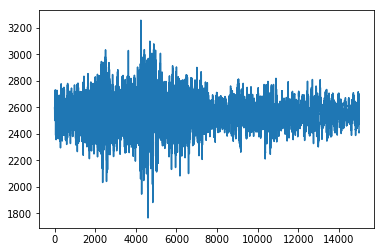

In [10]:
mic_pst_array = sess.get_perievent_stream_frames('microphone_0')
mic_pst_array.shape
plt.plot(np.nanmean(mic_pst_array, axis=0))

/home/zinch/conda/envs/msort/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


(66563, 114)

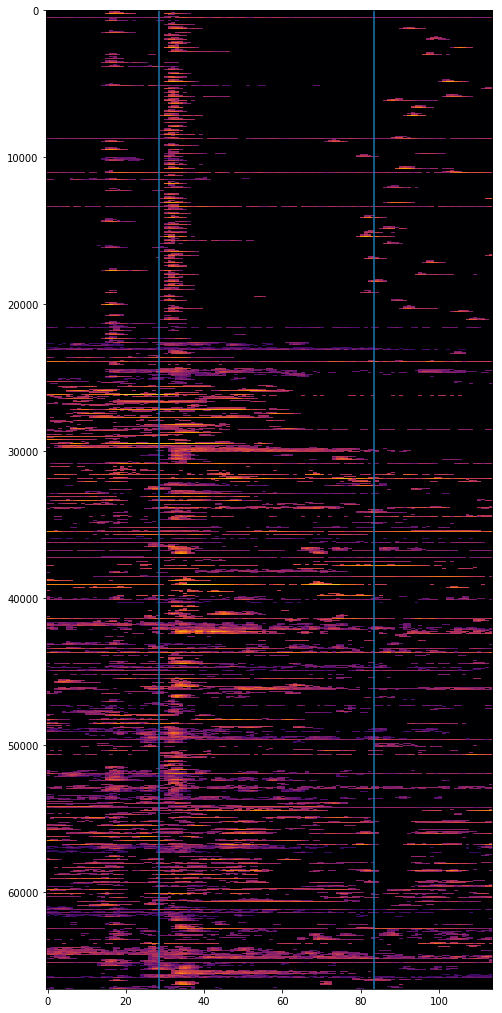

In [11]:
from scipy import signal as sg

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window=512, n_overlap=None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = int(n_window*0.75)
    if sigma is None:
        sigma = 1 / 200. * s_f

    # Make the spectrogram
    f, t, Sxx = sg.spectrogram(x, s_f, nperseg=n_window, noverlap=n_overlap, window=sg.gaussian(n_window, sigma),
                            scaling='spectrum')

    Sxx[[Sxx < np.max((Sxx) * 0.000055)]] = 1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms / 1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms / 1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    # Sxx = np.hstack((span_before, (Sxx), span_after))

    #if ax is None:
        #spec_fig, ax = plt.subplots()
        #ax = spec_fig.add_axes([0, 0, 1, 1])

    #ax.pcolormesh(((t - 0.5 * n_window / s_f) * 1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    #ax.set_xlim(-before_ms, after_ms + int(x.size / s_f * 1000.))
    #ax.set_ylim(0, 10000)
    #ax.imshow(np.log(Sxx[::-1]), aspect='auto', cmap='inferno', rasterized=True)
    # ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    return Sxx

sxx = plot_spectrogram(mic_pst_array[:, :, 0], 0, 0, 20000);
sxx.shape

many_spec = [plot_spectrogram(mic_pst_array[i, :, 0], 0, 0, 20000) for i in np.arange(mic_pst_array.shape[0])];
spec_arr = np.vstack(many_spec)
fig, ax = plt.subplots(figsize=(8, 18))
mark = viz_par['pre_samples']/viz_par['span'] * spec_arr.shape[1] * (-1)

ax.imshow(np.log(spec_arr[::-1]), aspect='auto', cmap='inferno')

ax.axvline(x=mark+15)
ax.axvline(x=mark-40)
spec_arr.shape

## View units

In [12]:
sess.exp_struct

{'folders': {'raw': '/mnt/zuperfinchjr/Data/p1j1/Ephys/raw/2019-02-27_1800_02',
  'kwik': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02',
  'msort': '/media/zinch/Windows/experiment/p1j1/Ephys/msort/2019-02-27_1800_02'},
 'files': {'par': '/media/zinch/Windows/experiment/p1j1/Ephys/msort/2019-02-27_1800_02/params.json',
  'set': '/mnt/zuperfinchjr/Data/p1j1/Ephys/raw/2019-02-27_1800_02/settings.isf',
  'rig': '/mnt/zuperfinchjr/Data/p1j1/Ephys/raw/2019-02-27_1800_02/rig.json',
  'kwd': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02/streams.kwd',
  'kwik': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02/spikes.kwik',
  'kwe': '/media/zinch/Windows/experiment/p1j1/Ephys/kwik/2019-02-27_1800_02/events.kwe',
  'mda_raw': '/media/zinch/Windows/experiment/p1j1/Ephys/msort/2019-02-27_1800_02/raw.mda'}}

2019-03-01 17:00:01,550 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for all, mind that this only works if all recs have the same setting


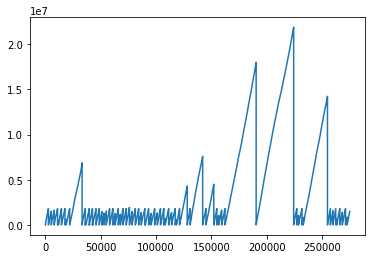

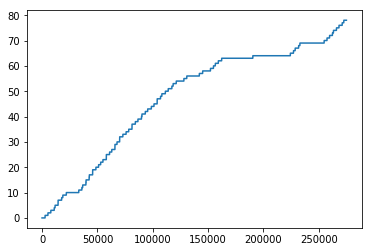

In [13]:
from pipefinch.h5tools.kwik import kwikfunctions as kwkf
from pipefinch.neural import units
reload(units)
reload(et)
all_clu = kwkf.list_units(sess.kwik_path)

i_unit = 24

current_clu = all_clu[i_unit]
a_unit = units.Unit(i_unit, sess.kwik_path, sess.kwd_path, port=sess.probe_port)
t, r = a_unit.get_time_stamps()

reload(kwkf)
kwkf.list_units(sess.kwik_path)['clu']
plt.plot(t)
plt.figure()
plt.plot(r)

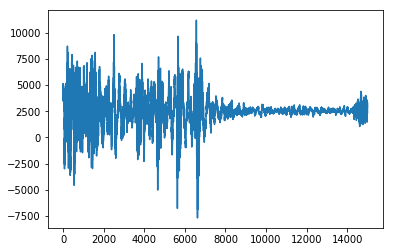

In [14]:
mic_stream = sess.get_mic_stream()[10]
plt.plot(mic_stream)

2019-03-01 17:00:06,024 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for all, mind that this only works if all recs have the same setting
2019-03-01 17:00:06,313 - root - INFO - filter recs
/home/zinch/conda/envs/msort/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


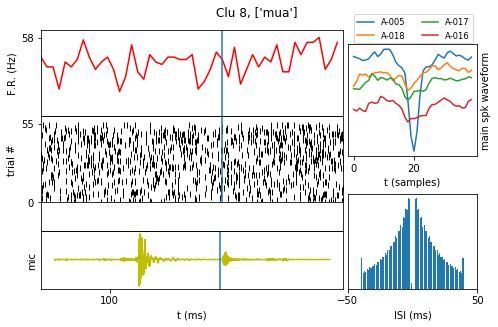

In [15]:
### import seaborn as sns
from pipefinch.neural import basic_plot as bp
reload(units)
reload(bp)
def plot_unit(sess, clu, fig=None):
    a_unit = units.Unit(clu, sess.kwik_path, sess.kwd_path, port=sess.probe_port)
    sorted_recs = sess.get_sorted_recs()
    
    if fig is None:
        fig = plt.figure()
        fig_ax = {}
    fig_width = 0.7
    fig_ax['raster'] = fig.add_axes([0,.3,fig_width,0.3])
    fig_ax['histogram'] = fig.add_axes([0,.6,fig_width,0.3])
    fig_ax['spectrogram'] = fig.add_axes([0,0,fig_width,0.2])
    fig_ax['synthesis'] = fig.add_axes([0,.2,fig_width,0.1])
    fig_ax['waveform'] = fig.add_axes([fig_width + .01, .45 + .01, 
                                                     1 - fig_width, 0.4 - 0.01])
    fig_ax['correlogram'] = fig.add_axes([fig_width +.01 ,0 , 
                                                        1 - fig_width, 0.45 - .12])
    for ax in fig_ax.values():
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    # plot raster, histogram, isi distribution
    all_rec, all_start = sess.get_event_stamps(filter_recs=sorted_recs)
    a_raster = a_unit.get_raster(all_start, all_rec, sess.viz_par['span'], return_ms=True)
    bp.plot_trial_raster(a_raster, ev_marks={'song': -sess.viz_par['pre_ms']}, ax=fig_ax['raster']);
    bp.plot_trial_raster(a_raster, ev_marks={'song': -sess.viz_par['pre_ms']}, bin_size=10, ax=fig_ax['histogram']);
    #fig_ax['histogram'].yaxis.set_ticks([0, a_raster.shape[0]])
    #fig_ax['raster'].yaxis.set_ticks([0, a_raster.shape[0]])
    
    # instad of spectrogram, plot one example song
    ax = fig_ax['spectrogram']
    mic_stream = sess.get_mic_stream()[1]
    t_ms = np.arange(mic_stream.size)/sess.s_f * 1000
    ax.plot(t_ms, mic_stream, 'y')
    ax.xaxis.set_ticks(np.arange(100, t_ms[-1], 500))
    ax.axvline(x=-sess.viz_par['pre_ms'])
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('mic')
    
    
    # pot isi, rec presence
    isi_dist = a_unit.get_isi_dist(max_t=40)
    fig_ax['correlogram'].bar(*isi_dist)
    fig_ax['correlogram'].set_xlabel('ISI (ms)')
    fig_ax['correlogram'].xaxis.set_ticks([-50, 50])
    
    
    #plot main waveform
    main_wave = a_unit.get_unit_main_wave(n_chans=4)
    main_chan_names = a_unit.get_unit_main_chans_names(n_chans=4)
    ax = fig_ax['waveform']
    #ax.plot(main_wave.mean(axis=0))
    #sns.tsplot(main_wave, ax=ax, err_style='boot_traces', n_boot=100)
    #sns.tsplot(main_wave, ax=ax, ci=95, )
    ax.plot(np.mean(main_wave, axis=0))
    ax.legend(main_chan_names, ncol=2, fontsize='small', loc='upper right', bbox_to_anchor=(1., 1.3))
    ax.xaxis.set_ticks([0, 20])
    ax.set_xlabel('t (samples)')
    ax.set_ylabel('main spk waveform')
    ax.yaxis.set_label_position("right")
    
    
    fig.suptitle('Clu {}, {}'.format(clu, a_unit.get_attrs()['tags']))
    plt.tight_layout()
    return fig


fig = plot_unit(sess, 8);



2019-03-01 17:00:12,591 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for all, mind that this only works if all recs have the same setting
2019-03-01 17:00:13,201 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for all, mind that this only works if all recs have the same setting
2019-03-01 17:00:13,476 - root - INFO - filter recs
/home/zinch/conda/envs/msort/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
2019-03-01 17:00:14,488 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for all, mind that this only works if all recs have the same setting
2019-03-01 17:00:15,091 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for

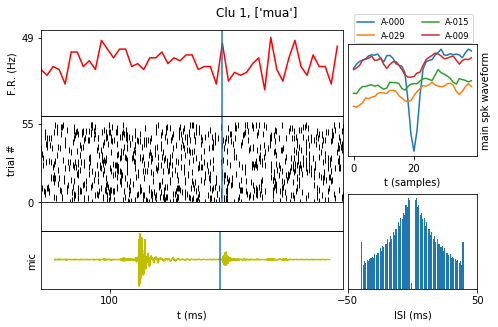

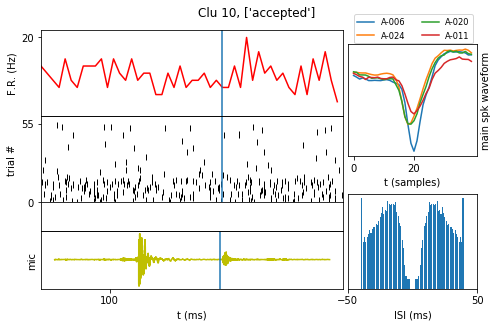

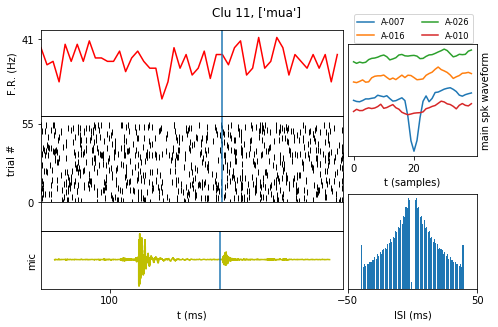

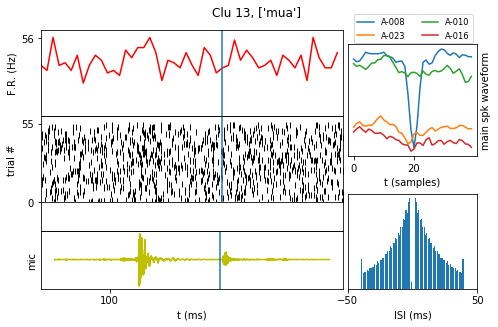

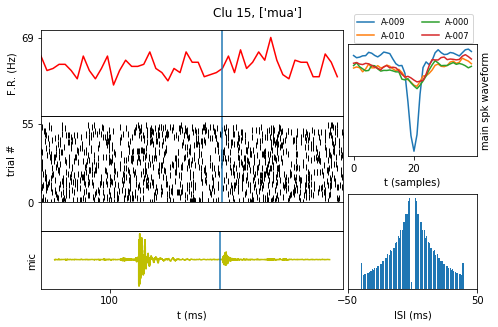

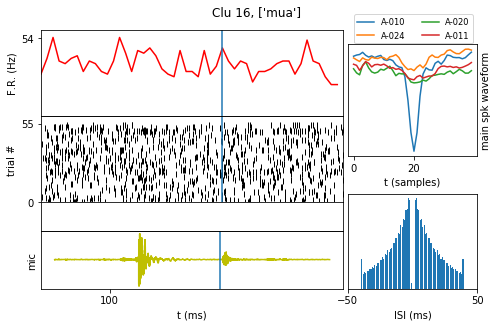

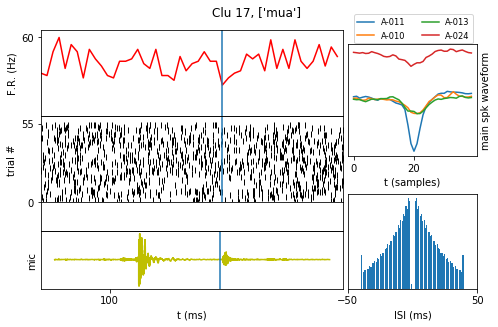

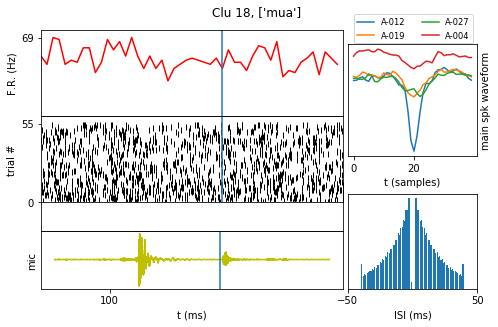

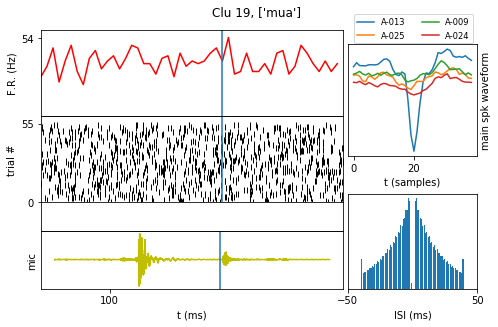

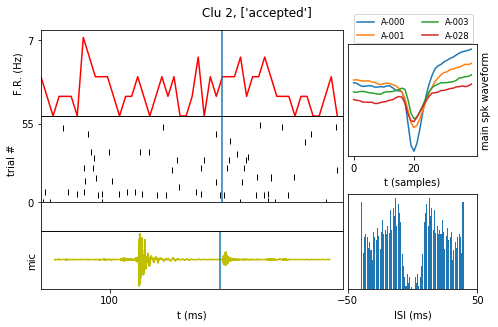

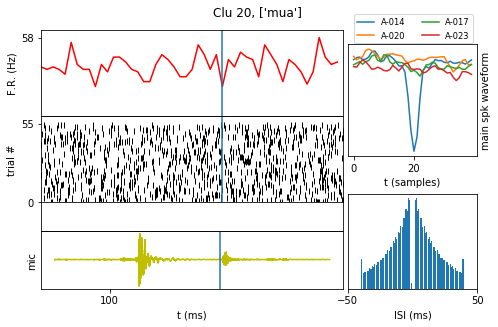

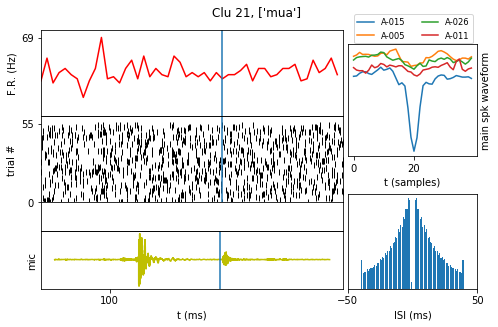

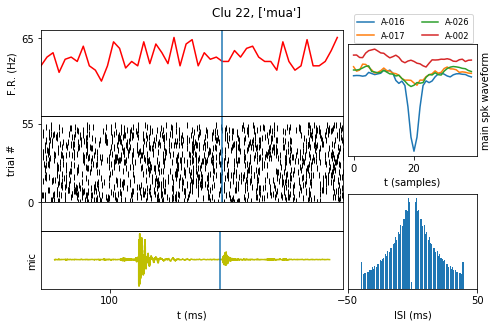

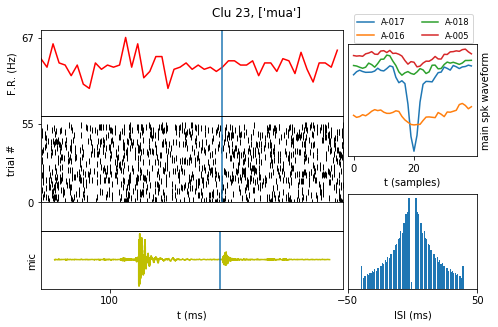

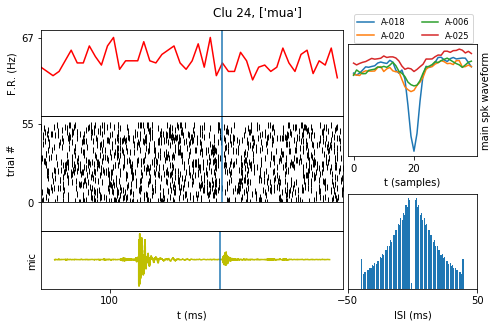

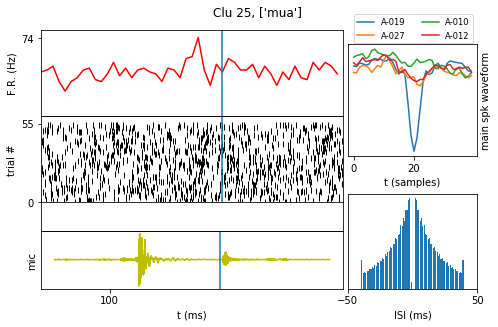

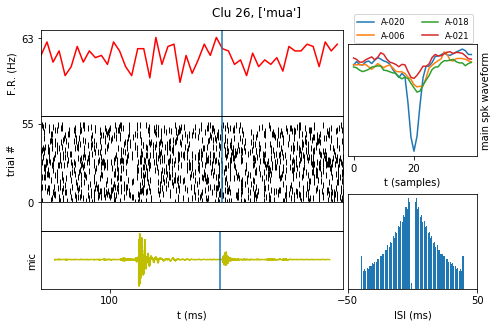

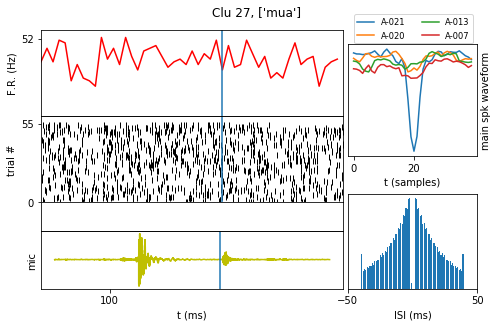

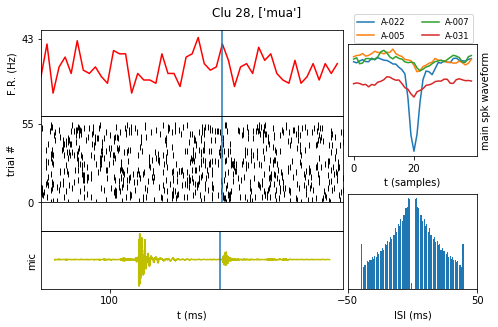

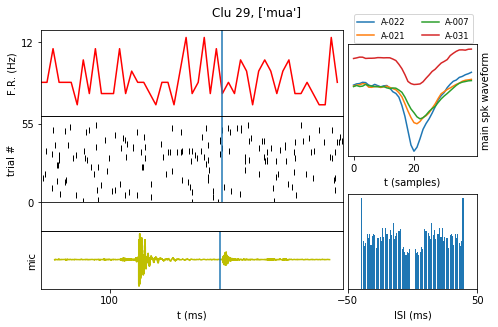

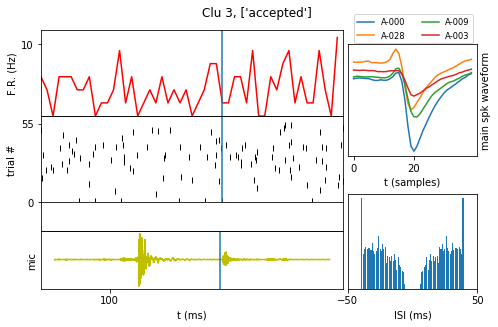

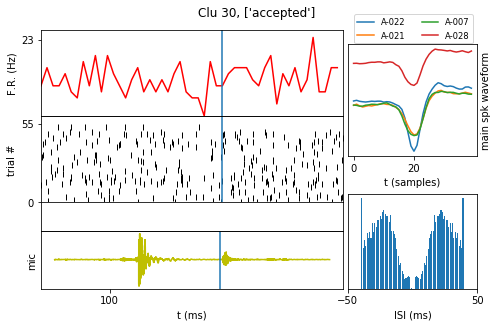

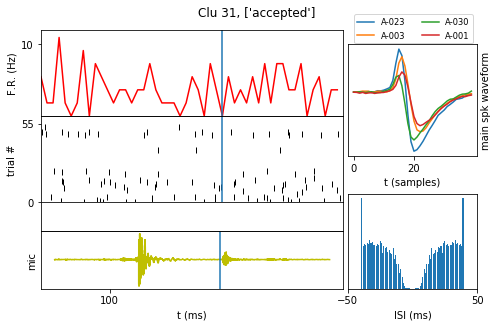

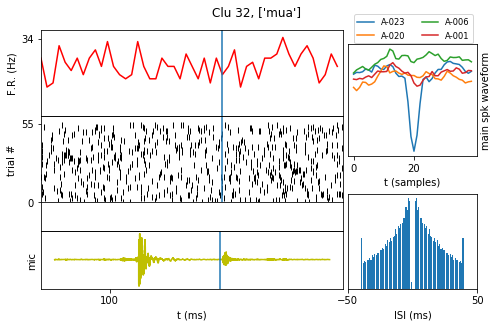

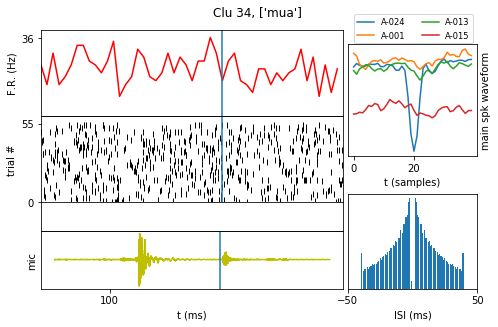

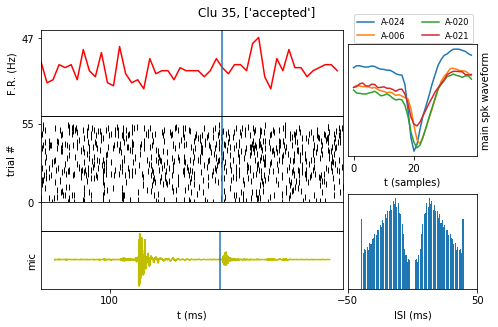

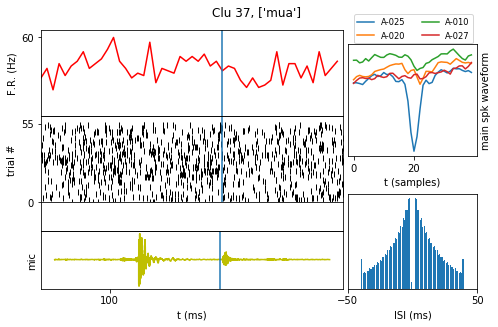

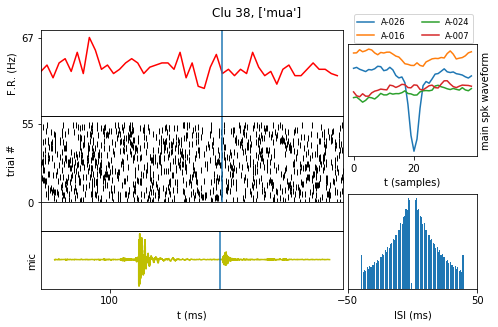

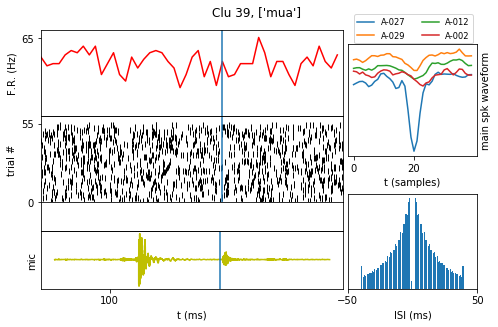

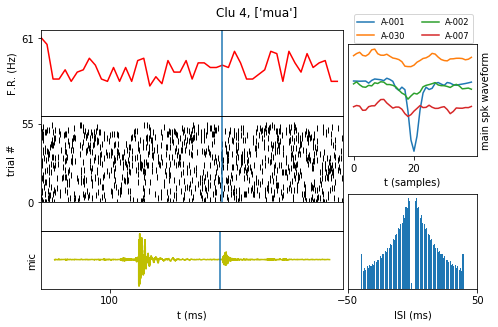

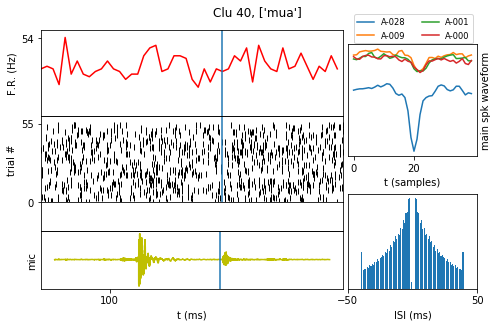

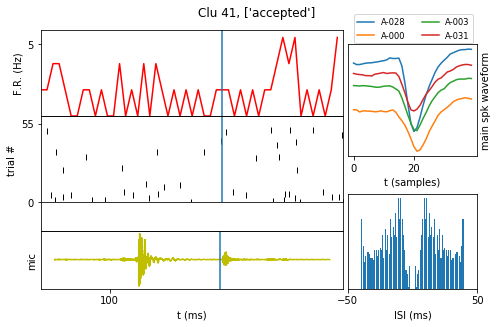

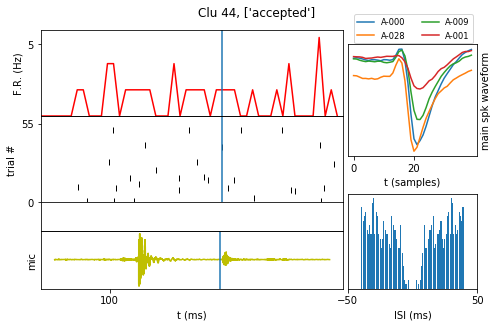

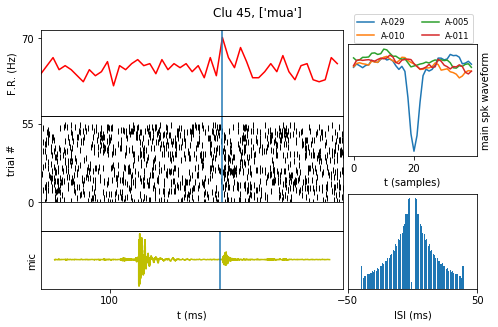

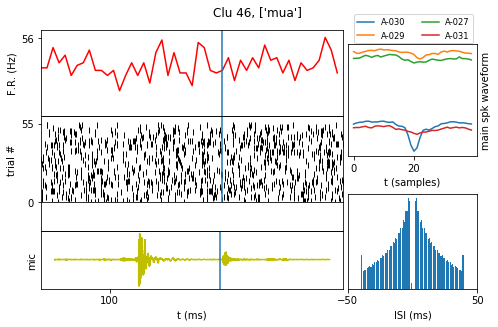

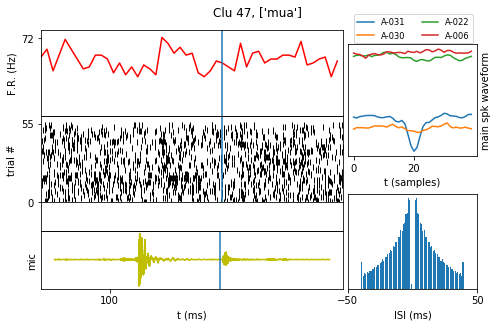

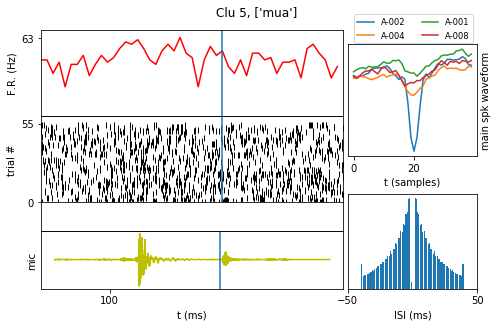

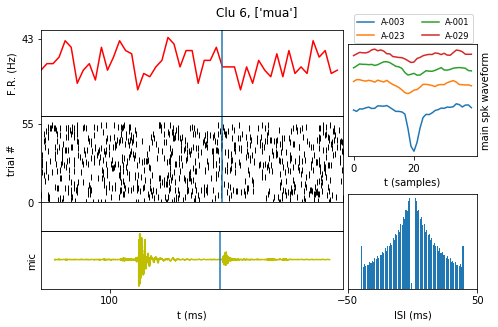

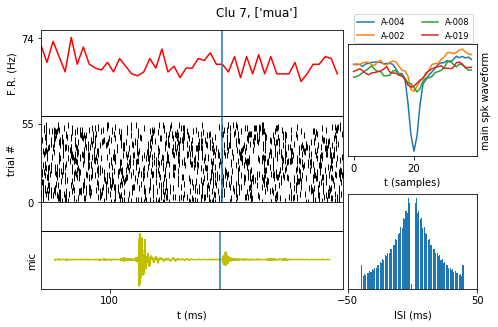

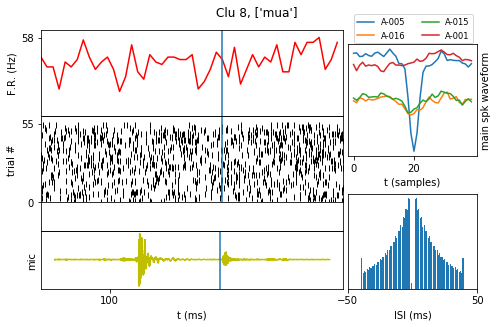

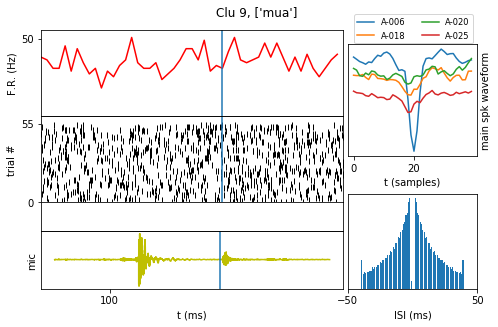

In [16]:
def plot_all_rasters(sess, only_tags=['accepted', 'mua', 'unsorted']):
    units_list = kwkf.list_units(sess.kwik_path)
    rasters_path = os.path.join(sess.exp_struct['folders']['kwik'], 'rasters')
    os.makedirs(rasters_path, exist_ok=True)
    for clu in units_list['clu']:
        a_unit = units.Unit(clu, sess.kwik_path, sess.kwd_path, port=sess.probe_port)
        unit_tags = a_unit.get_attrs()['tags']
        # if it is a rejected one don't even care
        if (not 'rejected' in unit_tags) and any([x in unit_tags for x in only_tags]):
            try:
                fig = plot_unit(sess, clu)
                fig_file = 'unit_{}_{:03d}.png'.format(0, clu)
                fig.savefig(os.path.join(rasters_path, fig_file), bbox_inches='tight')
            except:
                logger.warn('Failed to plot clu {}'.format(clu))
                continue
        
plot_all_rasters(sess, only_tags = ['accepted', 'mua', 'unsorted'])

In [24]:
reload(units)

<module 'pipefinch.neural.units' from '/home/zinch/repos/pipefinch/pipefinch/neural/units.py'>

In [50]:
a_unit = units.Unit(8, sess.kwik_path, sess.kwd_path, port=sess.probe_port)
a_unit.get_time_stamps()
a_unit.get_attrs()
a_unit.get_unit_chan_names()
a_unit.get_unit_main_chans_names()

2019-02-27 13:04:28,869 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for all, mind that this only works if all recs have the same setting


array(['D-006', 'D-004', 'D-007', 'D-008'], dtype='<U6')

In [97]:
signal.sosfilt.

Signature: signal.sosfilt(sos, x, axis=-1, zi=None)
Docstring:
Filter data along one dimension using cascaded second-order sections.

Filter a data sequence, `x`, using a digital IIR filter defined by
`sos`. This is implemented by performing `lfilter` for each
second-order section.  See `lfilter` for details.

Parameters
----------
sos : array_like
    Array of second-order filter coefficients, must have shape
    ``(n_sections, 6)``. Each row corresponds to a second-order
    section, with the first three columns providing the numerator
    coefficients and the last three providing the denominator
    coefficients.
x : array_like
    An N-dimensional input array.
axis : int, optional
    The axis of the input data array along which to apply the
    linear filter. The filter is applied to each subarray along
    this axis.  Default is -1.
zi : array_like, optional
    Initial conditions for the cascaded filter delays.  It is a (at
    least 2D) vector of shape ``(n_sections, ..., 2, ..

In [90]:
from scipy import signal
neural_chan_filter = signal.butter(10, [600, 7500], 'bandpass', fs=sess.s_f, output='sos')


In [73]:
a_unit.get_unit_main_chans(4)


(array([1, 0, 3, 5]), array([1, 0, 3, 5]))

In [41]:
a_unit.get_all_rec_meta()

AttributeError: 'Unit' object has no attribute 'get_all_rec_meta'

In [28]:
#plot main waveform

spikes = a_unit.
main_wave = a_unit.get_unit_main_wave(n_chans=4)
#ax.plot(main_wave.mean(axis=0))
sns.tsplot(main_wave, ci=95)
#sns.lineplot(ci=95, data=main_wave)

2019-02-27 11:12:24,481 - pipefinch.neural.units - WARNING - You are getting channel locations from one rec and using for all, mind that this only works if all recs have the same setting


ValueError: need at least one array to stack

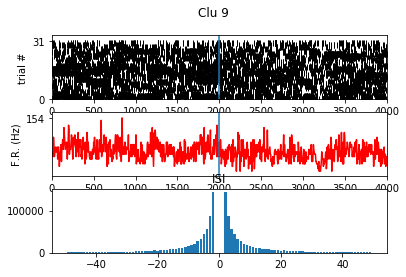

In [59]:
def plot_unit(clu):
    f, axs = plt.subplots(3, 1, sharex=False);
    a_unit = units.Unit(clu, sess.kwik_path, sess.kwd_path)
    t, r = a_unit.get_time_stamps()
    all_rec, all_start = sess.get_event_stamps()
    a_raster = a_unit.get_raster(all_start, all_rec, sess.viz_par['span'], return_ms=True)
    bp.plot_trial_raster(a_raster, ev_marks={'song': -sess.viz_par['pre_ms']}, ax=axs[0]);
    bp.plot_trial_raster(a_raster, ev_marks={'song': -sess.viz_par['pre_ms']}, bin_size=5, ax=axs[1]);
    isi_dist = a_unit.get_isi_dist(max_t=50)
    axs[2].bar(*isi_dist)
    axs[2].set_title('ISI')
    f.suptitle('Clu {}'.format(clu))                 
    return axs

plot_unit(9);

# DEBUG VIEWING UNITS

In [21]:
from pipefinch.neural import units
reload(kwdf)
reload(units)

a_unit = units.Unit(54, sess.kwik_path, sess.kwd_path)
t, r = a_unit.get_time_stamps()
a_unit.get_unit_spikes()

plt.plot(t)
plt.figure()
plt.plot(r)

KeyError: "Unable to open object (object '54' doesn't exist)"

In [ ]:
units.Unit(7, sess.kwik_path, sess.kwd_path).get_unit_spikes()

In [ ]:
reload(kwdf)

spk_arr = kwdf.collect_frames_fast(sess.kwd_path, r,  t-20,40, np.arange(32))

In [ ]:
spk_arr.shape

In [ ]:
sample = np.empty(0)
try:
    assert sample.size > 0, "no valid events"
except AssertionError as err:
    print(err.args)


In [ ]:
# get all unit waveforms in parallel
reload(units)
units.get_all_unit_waveforms(sess.kwik_path, sess.kwd_path)

In [ ]:
import h5py
kwkfile = h5py.File(sess.kwik_path, 'r')

r_path = "/channel_groups/0/spikes/recording"
clu_path = "/channel_groups/0/spikes/clusters/main"
t_path = '/channel_groups/0/spikes/time_samples'

recs = kwkfile[r_path][:]
clu = kwkfile[clu_path][:]
times = kwkfile[t_path][:]

In [ ]:
kwkfile.close()

In [ ]:
np.unique(recs)

In [ ]:
kwkfile['/channel_groups/0/spikes/clusters/main'][:]

In [ ]:
probe = {}
probe['a1x32-edge-5mm-20-177_H32'] = {i+1: (0, i*20) for i in range(32)}


# port_site maps
# each port is a dict {port: site}, where port is an int, site is an int
# port is

headstage = {}
headstage['intan-32-nn32'] = {23: 15, 22: 6, 21: 5, 20: 4, 19: 16, 18: 3, 17: 2, 16: 1,
                            15: 32, 14: 31, 13: 30, 12: 17, 11: 29, 10: 28, 9: 27, 8: 18,
                            24: 13, 25: 12, 26: 11, 27: 10, 28: 14, 29: 9, 30: 8, 31: 7,
                            0: 26, 1: 25, 2: 24, 3: 19, 4: 23, 5: 22, 6: 21, 7: 20}

def make_map(a_probe: dict, a_headstage: dict):
    # want to retrieve what coordinates are in each port of the headstage
    # headstage is {port: site}, probe is {site: coords}
    port_coords = {port: np.array(a_probe[site]) for port, site in sorted(a_headstage.items())}
    return (list(port_coords.values()))
    
np.vstack(make_map(probe['a1x32-edge-5mm-20-177_H32'], headstage['intan-32-nn32']))

In [ ]:
def site_port_map(probe_name: str, headstage_name: str):
    a_probe = probe[probe_name]
    a_headstage = headstage[headstage_name]

    return [h_port for site in a_probe.keys() for h_port, h_site in a_headstage.items() if h_site==site]

site_port_map('a1x32-edge-5mm-20-177_H32', 'intan-32-nn32')

In [23]:
import os